In [89]:
!pip install sentence-transformers
!pip install pandas


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [90]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch
import random

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [91]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [92]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [93]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [94]:
data = data.dropna()

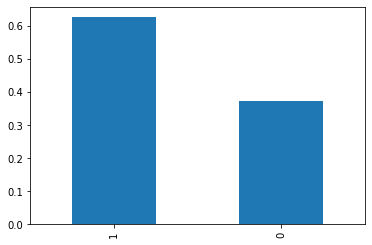

In [95]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [96]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [97]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [98]:
len(train_data)*1, type(train_labels), train_labels.shape


(3208, numpy.ndarray, (3208,))

In [100]:
train_data = train_data.iloc[0:3208]
train_labels = train_labels[0:3208]

In [101]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 3208, 3208)

In [102]:
def random_swap(sentence, n=2): 
    sentence = sentence.split()
    if len(sentence) > 4:

      length = range(len(sentence)-1) 
      #print(sentence, length)
      for _ in range(n):
          idx1, idx2 = random.sample(length, 2)
          sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
          #print(idx1, idx2, sentence)
      return ' '.join(sentence)
    return ' '.join(sentence)

In [103]:
random_swap("Hi i am there where are you")

'Hi there am where i are you'

In [104]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs, datatype='train'):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)
  i=0

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))
    
    if datatype=='train' and random.random() >= 0.5:
      sAns = random_swap(sentence2[idxA])
      #print(sAns)
      pairs.append(InputExample(texts=[dAns, sAns], label=label))
      i = i+1
  
  print("No.of augmented examples : ", i)

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [105]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [106]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples, datatype='test')

No.of augmented examples :  0


In [107]:
len(test_examples)

802

In [108]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

No.of augmented examples :  1610


In [109]:
len(train_examples)

4818

In [110]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [111]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [112]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 21:04:41 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-07 21:04:42 - Use pytorch device: cuda
2022-09-07 21:04:42 - Softmax loss: #Vectors concatenated: 3
302


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:05:07 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 21:05:07 - Accuracy with Cosine-Similarity:           79.18	(Threshold: 0.3771)
2022-09-07 21:05:07 - F1 with Cosine-Similarity:                 85.13	(Threshold: 0.2807)
2022-09-07 21:05:07 - Precision with Cosine-Similarity:          77.10
2022-09-07 21:05:07 - Recall with Cosine-Similarity:             95.03
2022-09-07 21:05:07 - Average Precision with Cosine-Similarity:  91.19

2022-09-07 21:05:07 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 369.5582)
2022-09-07 21:05:07 - F1 with Manhattan-Distance:                 84.68	(Threshold: 422.2367)
2022-09-07 21:05:07 - Precision with Manhattan-Distance:          75.99
2022-09-07 21:05:07 - Recall with Manhattan-Distance:             95.63
2022-09-07 21:05:07 - Average Precision with Manhattan-Distance:  91.37

2022-09-07 21:05:07 - Accuracy with Euclidean-Distance:           79.80	(Threshold: 16.6526)
2022-09-07 21:05:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:05:33 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 21:05:34 - Accuracy with Cosine-Similarity:           82.04	(Threshold: 0.3734)
2022-09-07 21:05:34 - F1 with Cosine-Similarity:                 86.58	(Threshold: 0.2707)
2022-09-07 21:05:34 - Precision with Cosine-Similarity:          80.07
2022-09-07 21:05:34 - Recall with Cosine-Similarity:             94.23
2022-09-07 21:05:34 - Average Precision with Cosine-Similarity:  91.58

2022-09-07 21:05:34 - Accuracy with Manhattan-Distance:           81.92	(Threshold: 394.9049)
2022-09-07 21:05:34 - F1 with Manhattan-Distance:                 86.23	(Threshold: 434.1912)
2022-09-07 21:05:34 - Precision with Manhattan-Distance:          78.78
2022-09-07 21:05:34 - Recall with Manhattan-Distance:             95.23
2022-09-07 21:05:34 - Average Precision with Manhattan-Distance:  91.77

2022-09-07 21:05:34 - Accuracy with Euclidean-Distance:           82.04	(Threshold: 17.8175)
2022-09-07 21:05:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:05:59 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 21:06:00 - Accuracy with Cosine-Similarity:           81.92	(Threshold: 0.2321)
2022-09-07 21:06:00 - F1 with Cosine-Similarity:                 86.43	(Threshold: 0.1899)
2022-09-07 21:06:00 - Precision with Cosine-Similarity:          81.15
2022-09-07 21:06:00 - Recall with Cosine-Similarity:             92.45
2022-09-07 21:06:00 - Average Precision with Cosine-Similarity:  91.53

2022-09-07 21:06:00 - Accuracy with Manhattan-Distance:           82.42	(Threshold: 446.8201)
2022-09-07 21:06:00 - F1 with Manhattan-Distance:                 86.91	(Threshold: 448.0668)
2022-09-07 21:06:00 - Precision with Manhattan-Distance:          81.53
2022-09-07 21:06:00 - Recall with Manhattan-Distance:             93.04
2022-09-07 21:06:00 - Average Precision with Manhattan-Distance:  91.74

2022-09-07 21:06:00 - Accuracy with Euclidean-Distance:           82.54	(Threshold: 20.9417)
2022-09-07 21:06:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:06:24 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 21:06:25 - Accuracy with Cosine-Similarity:           82.04	(Threshold: 0.1150)
2022-09-07 21:06:25 - F1 with Cosine-Similarity:                 86.54	(Threshold: 0.1150)
2022-09-07 21:06:25 - Precision with Cosine-Similarity:          81.66
2022-09-07 21:06:25 - Recall with Cosine-Similarity:             92.05
2022-09-07 21:06:25 - Average Precision with Cosine-Similarity:  91.01

2022-09-07 21:06:25 - Accuracy with Manhattan-Distance:           82.04	(Threshold: 443.2008)
2022-09-07 21:06:25 - F1 with Manhattan-Distance:                 86.49	(Threshold: 474.7016)
2022-09-07 21:06:25 - Precision with Manhattan-Distance:          81.88
2022-09-07 21:06:25 - Recall with Manhattan-Distance:             91.65
2022-09-07 21:06:25 - Average Precision with Manhattan-Distance:  91.21

2022-09-07 21:06:25 - Accuracy with Euclidean-Distance:           82.29	(Threshold: 21.5009)
2022-09-07 21:06:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:06:50 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 21:06:50 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.0301)
2022-09-07 21:06:50 - F1 with Cosine-Similarity:                 86.40	(Threshold: 0.0301)
2022-09-07 21:06:50 - Precision with Cosine-Similarity:          80.80
2022-09-07 21:06:50 - Recall with Cosine-Similarity:             92.84
2022-09-07 21:06:50 - Average Precision with Cosine-Similarity:  91.91

2022-09-07 21:06:50 - Accuracy with Manhattan-Distance:           81.92	(Threshold: 503.3859)
2022-09-07 21:06:50 - F1 with Manhattan-Distance:                 86.59	(Threshold: 503.3859)
2022-09-07 21:06:50 - Precision with Manhattan-Distance:          80.97
2022-09-07 21:06:50 - Recall with Manhattan-Distance:             93.04
2022-09-07 21:06:50 - Average Precision with Manhattan-Distance:  92.00

2022-09-07 21:06:50 - Accuracy with Euclidean-Distance:           82.17	(Threshold: 23.3428)
2022-09-07 21:06:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:07:16 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 21:07:16 - Accuracy with Cosine-Similarity:           82.17	(Threshold: 0.2284)
2022-09-07 21:07:16 - F1 with Cosine-Similarity:                 86.34	(Threshold: 0.2239)
2022-09-07 21:07:16 - Precision with Cosine-Similarity:          83.09
2022-09-07 21:07:16 - Recall with Cosine-Similarity:             89.86
2022-09-07 21:07:16 - Average Precision with Cosine-Similarity:  91.87

2022-09-07 21:07:16 - Accuracy with Manhattan-Distance:           82.42	(Threshold: 451.4351)
2022-09-07 21:07:16 - F1 with Manhattan-Distance:                 86.55	(Threshold: 464.7237)
2022-09-07 21:07:16 - Precision with Manhattan-Distance:          82.64
2022-09-07 21:07:16 - Recall with Manhattan-Distance:             90.85
2022-09-07 21:07:16 - Average Precision with Manhattan-Distance:  91.98

2022-09-07 21:07:16 - Accuracy with Euclidean-Distance:           82.29	(Threshold: 20.3462)
2022-09-07 21:07:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:07:41 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 21:07:42 - Accuracy with Cosine-Similarity:           81.80	(Threshold: 0.3310)
2022-09-07 21:07:42 - F1 with Cosine-Similarity:                 85.92	(Threshold: -0.0507)
2022-09-07 21:07:42 - Precision with Cosine-Similarity:          79.97
2022-09-07 21:07:42 - Recall with Cosine-Similarity:             92.84
2022-09-07 21:07:42 - Average Precision with Cosine-Similarity:  91.35

2022-09-07 21:07:42 - Accuracy with Manhattan-Distance:           82.04	(Threshold: 425.4974)
2022-09-07 21:07:42 - F1 with Manhattan-Distance:                 86.02	(Threshold: 436.5212)
2022-09-07 21:07:42 - Precision with Manhattan-Distance:          84.06
2022-09-07 21:07:42 - Recall with Manhattan-Distance:             88.07
2022-09-07 21:07:42 - Average Precision with Manhattan-Distance:  91.42

2022-09-07 21:07:42 - Accuracy with Euclidean-Distance:           82.04	(Threshold: 19.4588)
2022-09-07 21:07

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:08:07 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 21:08:07 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.2548)
2022-09-07 21:08:07 - F1 with Cosine-Similarity:                 85.82	(Threshold: -0.1004)
2022-09-07 21:08:07 - Precision with Cosine-Similarity:          80.38
2022-09-07 21:08:07 - Recall with Cosine-Similarity:             92.05
2022-09-07 21:08:07 - Average Precision with Cosine-Similarity:  91.62

2022-09-07 21:08:07 - Accuracy with Manhattan-Distance:           81.55	(Threshold: 449.4909)
2022-09-07 21:08:07 - F1 with Manhattan-Distance:                 85.90	(Threshold: 515.7874)
2022-09-07 21:08:07 - Precision with Manhattan-Distance:          80.99
2022-09-07 21:08:07 - Recall with Manhattan-Distance:             91.45
2022-09-07 21:08:07 - Average Precision with Manhattan-Distance:  91.70

2022-09-07 21:08:07 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 20.3508)
2022-09-07 21:08

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:08:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 21:08:33 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.5262)
2022-09-07 21:08:33 - F1 with Cosine-Similarity:                 85.77	(Threshold: 0.1051)
2022-09-07 21:08:33 - Precision with Cosine-Similarity:          81.06
2022-09-07 21:08:33 - Recall with Cosine-Similarity:             91.05
2022-09-07 21:08:33 - Average Precision with Cosine-Similarity:  91.69

2022-09-07 21:08:33 - Accuracy with Manhattan-Distance:           81.55	(Threshold: 418.9033)
2022-09-07 21:08:33 - F1 with Manhattan-Distance:                 85.88	(Threshold: 472.9485)
2022-09-07 21:08:33 - Precision with Manhattan-Distance:          81.57
2022-09-07 21:08:33 - Recall with Manhattan-Distance:             90.66
2022-09-07 21:08:33 - Average Precision with Manhattan-Distance:  91.74

2022-09-07 21:08:33 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 19.3677)
2022-09-07 21:08:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:08:57 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 21:08:58 - Accuracy with Cosine-Similarity:           81.42	(Threshold: 0.2768)
2022-09-07 21:08:58 - F1 with Cosine-Similarity:                 85.77	(Threshold: 0.0558)
2022-09-07 21:08:58 - Precision with Cosine-Similarity:          81.06
2022-09-07 21:08:58 - Recall with Cosine-Similarity:             91.05
2022-09-07 21:08:58 - Average Precision with Cosine-Similarity:  91.62

2022-09-07 21:08:58 - Accuracy with Manhattan-Distance:           81.80	(Threshold: 442.1555)
2022-09-07 21:08:58 - F1 with Manhattan-Distance:                 85.96	(Threshold: 442.1555)
2022-09-07 21:08:58 - Precision with Manhattan-Distance:          83.24
2022-09-07 21:08:58 - Recall with Manhattan-Distance:             88.87
2022-09-07 21:08:58 - Average Precision with Manhattan-Distance:  91.67

2022-09-07 21:08:58 - Accuracy with Euclidean-Distance:           81.80	(Threshold: 20.3088)
2022-09-07 21:08:

0.9201896789878903

In [113]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 21:09:01 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-07 21:09:01 - Use pytorch device: cuda
2022-09-07 21:09:01 - Softmax loss: #Vectors concatenated: 3
302


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:09:24 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 21:09:24 - Accuracy with Cosine-Similarity:           78.18	(Threshold: 0.4742)
2022-09-07 21:09:24 - F1 with Cosine-Similarity:                 84.30	(Threshold: 0.4043)
2022-09-07 21:09:24 - Precision with Cosine-Similarity:          76.80
2022-09-07 21:09:24 - Recall with Cosine-Similarity:             93.44
2022-09-07 21:09:24 - Average Precision with Cosine-Similarity:  88.87

2022-09-07 21:09:24 - Accuracy with Manhattan-Distance:           77.56	(Threshold: 572.6671)
2022-09-07 21:09:24 - F1 with Manhattan-Distance:                 83.73	(Threshold: 572.6671)
2022-09-07 21:09:24 - Precision with Manhattan-Distance:          76.78
2022-09-07 21:09:24 - Recall with Manhattan-Distance:             92.05
2022-09-07 21:09:24 - Average Precision with Manhattan-Distance:  88.58

2022-09-07 21:09:24 - Accuracy with Euclidean-Distance:           77.18	(Threshold: 26.0843)
2022-09-07 21:09:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:09:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 21:09:48 - Accuracy with Cosine-Similarity:           81.55	(Threshold: 0.3650)
2022-09-07 21:09:48 - F1 with Cosine-Similarity:                 86.35	(Threshold: 0.3621)
2022-09-07 21:09:48 - Precision with Cosine-Similarity:          80.55
2022-09-07 21:09:48 - Recall with Cosine-Similarity:             93.04
2022-09-07 21:09:48 - Average Precision with Cosine-Similarity:  90.77

2022-09-07 21:09:48 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 629.8227)
2022-09-07 21:09:48 - F1 with Manhattan-Distance:                 85.74	(Threshold: 670.4905)
2022-09-07 21:09:48 - Precision with Manhattan-Distance:          77.32
2022-09-07 21:09:48 - Recall with Manhattan-Distance:             96.22
2022-09-07 21:09:48 - Average Precision with Manhattan-Distance:  90.65

2022-09-07 21:09:48 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 28.7092)
2022-09-07 21:09:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:10:11 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 21:10:11 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.3621)
2022-09-07 21:10:11 - F1 with Cosine-Similarity:                 85.77	(Threshold: 0.3309)
2022-09-07 21:10:11 - Precision with Cosine-Similarity:          79.69
2022-09-07 21:10:11 - Recall with Cosine-Similarity:             92.84
2022-09-07 21:10:11 - Average Precision with Cosine-Similarity:  90.98

2022-09-07 21:10:11 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 724.6852)
2022-09-07 21:10:11 - F1 with Manhattan-Distance:                 85.90	(Threshold: 724.6852)
2022-09-07 21:10:11 - Precision with Manhattan-Distance:          78.77
2022-09-07 21:10:11 - Recall with Manhattan-Distance:             94.43
2022-09-07 21:10:11 - Average Precision with Manhattan-Distance:  91.16

2022-09-07 21:10:11 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 31.8598)
2022-09-07 21:10:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:10:34 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 21:10:35 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.4250)
2022-09-07 21:10:35 - F1 with Cosine-Similarity:                 85.34	(Threshold: 0.2799)
2022-09-07 21:10:35 - Precision with Cosine-Similarity:          80.00
2022-09-07 21:10:35 - Recall with Cosine-Similarity:             91.45
2022-09-07 21:10:35 - Average Precision with Cosine-Similarity:  91.94

2022-09-07 21:10:35 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 710.6583)
2022-09-07 21:10:35 - F1 with Manhattan-Distance:                 85.43	(Threshold: 804.5692)
2022-09-07 21:10:35 - Precision with Manhattan-Distance:          78.82
2022-09-07 21:10:35 - Recall with Manhattan-Distance:             93.24
2022-09-07 21:10:35 - Average Precision with Manhattan-Distance:  91.95

2022-09-07 21:10:35 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 32.2271)
2022-09-07 21:10:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:10:57 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 21:10:58 - Accuracy with Cosine-Similarity:           81.42	(Threshold: 0.3088)
2022-09-07 21:10:58 - F1 with Cosine-Similarity:                 86.06	(Threshold: 0.3088)
2022-09-07 21:10:58 - Precision with Cosine-Similarity:          81.27
2022-09-07 21:10:58 - Recall with Cosine-Similarity:             91.45
2022-09-07 21:10:58 - Average Precision with Cosine-Similarity:  91.86

2022-09-07 21:10:58 - Accuracy with Manhattan-Distance:           81.42	(Threshold: 747.5366)
2022-09-07 21:10:58 - F1 with Manhattan-Distance:                 85.87	(Threshold: 794.5005)
2022-09-07 21:10:58 - Precision with Manhattan-Distance:          80.17
2022-09-07 21:10:58 - Recall with Manhattan-Distance:             92.45
2022-09-07 21:10:58 - Average Precision with Manhattan-Distance:  91.92

2022-09-07 21:10:58 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 34.1864)
2022-09-07 21:10:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:11:21 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 21:11:21 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.3477)
2022-09-07 21:11:21 - F1 with Cosine-Similarity:                 86.21	(Threshold: 0.1560)
2022-09-07 21:11:21 - Precision with Cosine-Similarity:          79.30
2022-09-07 21:11:21 - Recall with Cosine-Similarity:             94.43
2022-09-07 21:11:21 - Average Precision with Cosine-Similarity:  91.25

2022-09-07 21:11:21 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 747.0155)
2022-09-07 21:11:21 - F1 with Manhattan-Distance:                 86.05	(Threshold: 861.7220)
2022-09-07 21:11:21 - Precision with Manhattan-Distance:          79.46
2022-09-07 21:11:21 - Recall with Manhattan-Distance:             93.84
2022-09-07 21:11:21 - Average Precision with Manhattan-Distance:  90.86

2022-09-07 21:11:21 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 34.5557)
2022-09-07 21:11:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:11:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 21:11:45 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.3046)
2022-09-07 21:11:45 - F1 with Cosine-Similarity:                 85.85	(Threshold: 0.2427)
2022-09-07 21:11:45 - Precision with Cosine-Similarity:          81.69
2022-09-07 21:11:45 - Recall with Cosine-Similarity:             90.46
2022-09-07 21:11:45 - Average Precision with Cosine-Similarity:  91.11

2022-09-07 21:11:45 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 816.8181)
2022-09-07 21:11:45 - F1 with Manhattan-Distance:                 85.90	(Threshold: 858.7174)
2022-09-07 21:11:45 - Precision with Manhattan-Distance:          79.63
2022-09-07 21:11:45 - Recall with Manhattan-Distance:             93.24
2022-09-07 21:11:45 - Average Precision with Manhattan-Distance:  90.50

2022-09-07 21:11:45 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 35.2383)
2022-09-07 21:11:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:12:07 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 21:12:08 - Accuracy with Cosine-Similarity:           81.42	(Threshold: 0.3698)
2022-09-07 21:12:08 - F1 with Cosine-Similarity:                 85.87	(Threshold: 0.2462)
2022-09-07 21:12:08 - Precision with Cosine-Similarity:          80.17
2022-09-07 21:12:08 - Recall with Cosine-Similarity:             92.45
2022-09-07 21:12:08 - Average Precision with Cosine-Similarity:  91.78

2022-09-07 21:12:08 - Accuracy with Manhattan-Distance:           81.30	(Threshold: 756.8619)
2022-09-07 21:12:08 - F1 with Manhattan-Distance:                 85.71	(Threshold: 784.6016)
2022-09-07 21:12:08 - Precision with Manhattan-Distance:          81.28
2022-09-07 21:12:08 - Recall with Manhattan-Distance:             90.66
2022-09-07 21:12:08 - Average Precision with Manhattan-Distance:  91.63

2022-09-07 21:12:08 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 35.8975)
2022-09-07 21:12:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:12:30 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 21:12:31 - Accuracy with Cosine-Similarity:           82.17	(Threshold: 0.3783)
2022-09-07 21:12:31 - F1 with Cosine-Similarity:                 86.42	(Threshold: 0.3701)
2022-09-07 21:12:31 - Precision with Cosine-Similarity:          82.73
2022-09-07 21:12:31 - Recall with Cosine-Similarity:             90.46
2022-09-07 21:12:31 - Average Precision with Cosine-Similarity:  91.73

2022-09-07 21:12:31 - Accuracy with Manhattan-Distance:           82.04	(Threshold: 758.1786)
2022-09-07 21:12:31 - F1 with Manhattan-Distance:                 86.34	(Threshold: 758.1786)
2022-09-07 21:12:31 - Precision with Manhattan-Distance:          82.58
2022-09-07 21:12:31 - Recall with Manhattan-Distance:             90.46
2022-09-07 21:12:31 - Average Precision with Manhattan-Distance:  91.25

2022-09-07 21:12:31 - Accuracy with Euclidean-Distance:           81.80	(Threshold: 35.1862)
2022-09-07 21:12:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:12:54 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 21:12:54 - Accuracy with Cosine-Similarity:           82.17	(Threshold: 0.3608)
2022-09-07 21:12:54 - F1 with Cosine-Similarity:                 86.42	(Threshold: 0.3373)
2022-09-07 21:12:54 - Precision with Cosine-Similarity:          82.73
2022-09-07 21:12:54 - Recall with Cosine-Similarity:             90.46
2022-09-07 21:12:54 - Average Precision with Cosine-Similarity:  91.69

2022-09-07 21:12:54 - Accuracy with Manhattan-Distance:           82.04	(Threshold: 776.0541)
2022-09-07 21:12:54 - F1 with Manhattan-Distance:                 86.34	(Threshold: 776.0541)
2022-09-07 21:12:54 - Precision with Manhattan-Distance:          82.58
2022-09-07 21:12:54 - Recall with Manhattan-Distance:             90.46
2022-09-07 21:12:54 - Average Precision with Manhattan-Distance:  91.13

2022-09-07 21:12:54 - Accuracy with Euclidean-Distance:           81.80	(Threshold: 35.3097)
2022-09-07 21:12:

0.9194502734839399

In [114]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 21:12:57 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-07 21:12:57 - Use pytorch device: cuda
2022-09-07 21:12:57 - Softmax loss: #Vectors concatenated: 3
302


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:13:22 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 21:13:23 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.4325)
2022-09-07 21:13:23 - F1 with Cosine-Similarity:                 85.40	(Threshold: 0.4148)
2022-09-07 21:13:23 - Precision with Cosine-Similarity:          80.24
2022-09-07 21:13:23 - Recall with Cosine-Similarity:             91.25
2022-09-07 21:13:23 - Average Precision with Cosine-Similarity:  90.47

2022-09-07 21:13:23 - Accuracy with Manhattan-Distance:           77.31	(Threshold: 308.1942)
2022-09-07 21:13:23 - F1 with Manhattan-Distance:                 83.82	(Threshold: 339.3217)
2022-09-07 21:13:23 - Precision with Manhattan-Distance:          75.48
2022-09-07 21:13:23 - Recall with Manhattan-Distance:             94.23
2022-09-07 21:13:23 - Average Precision with Manhattan-Distance:  88.35

2022-09-07 21:13:23 - Accuracy with Euclidean-Distance:           77.81	(Threshold: 15.2370)
2022-09-07 21:13:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:13:48 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 21:13:49 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.5470)
2022-09-07 21:13:49 - F1 with Cosine-Similarity:                 85.55	(Threshold: 0.4405)
2022-09-07 21:13:49 - Precision with Cosine-Similarity:          81.47
2022-09-07 21:13:49 - Recall with Cosine-Similarity:             90.06
2022-09-07 21:13:49 - Average Precision with Cosine-Similarity:  92.14

2022-09-07 21:13:49 - Accuracy with Manhattan-Distance:           81.67	(Threshold: 317.4021)
2022-09-07 21:13:49 - F1 with Manhattan-Distance:                 85.52	(Threshold: 327.0305)
2022-09-07 21:13:49 - Precision with Manhattan-Distance:          84.77
2022-09-07 21:13:49 - Recall with Manhattan-Distance:             86.28
2022-09-07 21:13:49 - Average Precision with Manhattan-Distance:  91.55

2022-09-07 21:13:49 - Accuracy with Euclidean-Distance:           81.67	(Threshold: 14.3430)
2022-09-07 21:13:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:14:14 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 21:14:15 - Accuracy with Cosine-Similarity:           82.29	(Threshold: 0.3709)
2022-09-07 21:14:15 - F1 with Cosine-Similarity:                 86.29	(Threshold: 0.3709)
2022-09-07 21:14:15 - Precision with Cosine-Similarity:          83.86
2022-09-07 21:14:15 - Recall with Cosine-Similarity:             88.87
2022-09-07 21:14:15 - Average Precision with Cosine-Similarity:  92.16

2022-09-07 21:14:15 - Accuracy with Manhattan-Distance:           82.17	(Threshold: 384.3081)
2022-09-07 21:14:15 - F1 with Manhattan-Distance:                 86.45	(Threshold: 384.3081)
2022-09-07 21:14:15 - Precision with Manhattan-Distance:          82.61
2022-09-07 21:14:15 - Recall with Manhattan-Distance:             90.66
2022-09-07 21:14:15 - Average Precision with Manhattan-Distance:  91.52

2022-09-07 21:14:15 - Accuracy with Euclidean-Distance:           81.67	(Threshold: 17.6669)
2022-09-07 21:14:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:14:41 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 21:14:41 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.2420)
2022-09-07 21:14:41 - F1 with Cosine-Similarity:                 85.55	(Threshold: 0.2420)
2022-09-07 21:14:41 - Precision with Cosine-Similarity:          84.63
2022-09-07 21:14:41 - Recall with Cosine-Similarity:             86.48
2022-09-07 21:14:41 - Average Precision with Cosine-Similarity:  92.08

2022-09-07 21:14:41 - Accuracy with Manhattan-Distance:           80.67	(Threshold: 410.6644)
2022-09-07 21:14:41 - F1 with Manhattan-Distance:                 85.42	(Threshold: 439.7142)
2022-09-07 21:14:41 - Precision with Manhattan-Distance:          80.14
2022-09-07 21:14:41 - Recall with Manhattan-Distance:             91.45
2022-09-07 21:14:41 - Average Precision with Manhattan-Distance:  91.54

2022-09-07 21:14:41 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 19.0319)
2022-09-07 21:14:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:15:07 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 21:15:07 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.4870)
2022-09-07 21:15:07 - F1 with Cosine-Similarity:                 85.66	(Threshold: 0.2685)
2022-09-07 21:15:07 - Precision with Cosine-Similarity:          81.51
2022-09-07 21:15:07 - Recall with Cosine-Similarity:             90.26
2022-09-07 21:15:07 - Average Precision with Cosine-Similarity:  92.09

2022-09-07 21:15:07 - Accuracy with Manhattan-Distance:           81.42	(Threshold: 357.1085)
2022-09-07 21:15:07 - F1 with Manhattan-Distance:                 85.29	(Threshold: 380.7945)
2022-09-07 21:15:07 - Precision with Manhattan-Distance:          84.14
2022-09-07 21:15:07 - Recall with Manhattan-Distance:             86.48
2022-09-07 21:15:07 - Average Precision with Manhattan-Distance:  91.96

2022-09-07 21:15:07 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 16.3195)
2022-09-07 21:15:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:15:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 21:15:33 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.6179)
2022-09-07 21:15:33 - F1 with Cosine-Similarity:                 85.79	(Threshold: 0.1547)
2022-09-07 21:15:33 - Precision with Cosine-Similarity:          79.59
2022-09-07 21:15:33 - Recall with Cosine-Similarity:             93.04
2022-09-07 21:15:33 - Average Precision with Cosine-Similarity:  92.31

2022-09-07 21:15:33 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 303.3241)
2022-09-07 21:15:33 - F1 with Manhattan-Distance:                 85.45	(Threshold: 424.8335)
2022-09-07 21:15:33 - Precision with Manhattan-Distance:          80.03
2022-09-07 21:15:33 - Recall with Manhattan-Distance:             91.65
2022-09-07 21:15:33 - Average Precision with Manhattan-Distance:  92.25

2022-09-07 21:15:33 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 19.1346)
2022-09-07 21:15:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:15:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 21:15:59 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.3226)
2022-09-07 21:15:59 - F1 with Cosine-Similarity:                 84.74	(Threshold: -0.2507)
2022-09-07 21:15:59 - Precision with Cosine-Similarity:          77.25
2022-09-07 21:15:59 - Recall with Cosine-Similarity:             93.84
2022-09-07 21:15:59 - Average Precision with Cosine-Similarity:  92.31

2022-09-07 21:15:59 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 400.1894)
2022-09-07 21:15:59 - F1 with Manhattan-Distance:                 84.34	(Threshold: 446.1268)
2022-09-07 21:15:59 - Precision with Manhattan-Distance:          83.04
2022-09-07 21:15:59 - Recall with Manhattan-Distance:             85.69
2022-09-07 21:15:59 - Average Precision with Manhattan-Distance:  91.88

2022-09-07 21:15:59 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 18.8157)
2022-09-07 21:15

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:16:24 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 21:16:25 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.5335)
2022-09-07 21:16:25 - F1 with Cosine-Similarity:                 85.24	(Threshold: 0.0523)
2022-09-07 21:16:25 - Precision with Cosine-Similarity:          79.52
2022-09-07 21:16:25 - Recall with Cosine-Similarity:             91.85
2022-09-07 21:16:25 - Average Precision with Cosine-Similarity:  92.55

2022-09-07 21:16:25 - Accuracy with Manhattan-Distance:           81.30	(Threshold: 366.3255)
2022-09-07 21:16:25 - F1 with Manhattan-Distance:                 85.21	(Threshold: 366.3255)
2022-09-07 21:16:25 - Precision with Manhattan-Distance:          84.54
2022-09-07 21:16:25 - Recall with Manhattan-Distance:             85.88
2022-09-07 21:16:25 - Average Precision with Manhattan-Distance:  92.33

2022-09-07 21:16:25 - Accuracy with Euclidean-Distance:           81.42	(Threshold: 16.7438)
2022-09-07 21:16:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:16:50 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 21:16:51 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.4545)
2022-09-07 21:16:51 - F1 with Cosine-Similarity:                 84.94	(Threshold: 0.3095)
2022-09-07 21:16:51 - Precision with Cosine-Similarity:          83.08
2022-09-07 21:16:51 - Recall with Cosine-Similarity:             86.88
2022-09-07 21:16:51 - Average Precision with Cosine-Similarity:  92.24

2022-09-07 21:16:51 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 365.0852)
2022-09-07 21:16:51 - F1 with Manhattan-Distance:                 84.66	(Threshold: 406.3455)
2022-09-07 21:16:51 - Precision with Manhattan-Distance:          82.73
2022-09-07 21:16:51 - Recall with Manhattan-Distance:             86.68
2022-09-07 21:16:51 - Average Precision with Manhattan-Distance:  92.00

2022-09-07 21:16:51 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 16.8729)
2022-09-07 21:16:

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

2022-09-07 21:17:16 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 21:17:16 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.3661)
2022-09-07 21:17:16 - F1 with Cosine-Similarity:                 84.90	(Threshold: 0.3661)
2022-09-07 21:17:16 - Precision with Cosine-Similarity:          83.75
2022-09-07 21:17:16 - Recall with Cosine-Similarity:             86.08
2022-09-07 21:17:16 - Average Precision with Cosine-Similarity:  92.17

2022-09-07 21:17:16 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 368.4842)
2022-09-07 21:17:16 - F1 with Manhattan-Distance:                 84.76	(Threshold: 481.5500)
2022-09-07 21:17:16 - Precision with Manhattan-Distance:          79.14
2022-09-07 21:17:16 - Recall with Manhattan-Distance:             91.25
2022-09-07 21:17:16 - Average Precision with Manhattan-Distance:  91.92

2022-09-07 21:17:16 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 16.4921)
2022-09-07 21:17:

0.9254943408138846

In [115]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [116]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.4935]])